Notes

Frequency: The speed of the vibration. Measured as the number of wave cycles in a second.

Hz: The measure of the frequency. 10 hz = 10 wave cycles per second.

Mel: similar to Hz the mel scale is a quasi logarithmic scale for measuring frequency

Amplitude: The size of the vibration, determines how loud the sound is

dB: measure of amplitude. On a logarithmic scale

Hop length: How much time you can advance the analysis point of origin from frame to frame. Essentially the overlap between frame. Lower hop length = more overlap = smoother results, but it is computationally more expensive

fft: fast fourier transformatin. Microphones measure air pressure. Pressure is a combination of pure frequencies. The fourier transformation is the process of decomposing pressure into pure frequencies. 

In [1]:
import librosa
import librosa.display

import numpy as np
import matplotlib.pyplot as plt

import pandas as pd

from IPython.display import Audio

import os
import shutil

import skimage
import skimage.io

from PIL import Image

# Explanation

In [10]:
# load the audio sample, y is a numpy array representing the audio
# and sr is the sample rate, or the number of samples per second of audio
# by default audio is mixed to mono and resampled at 22050 Hz
y, sr = librosa.load('Data/ryerson/Actor_01/03-01-01-01-01-01-01.wav')

# trim the silent edges
sample, _ = librosa.effects.trim(y)
# play the audio
#Audio(data=sample, rate=sr)

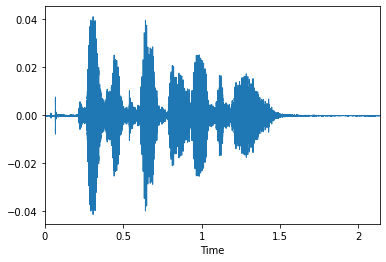

In [14]:
# show a waveplot
librosa.display.waveplot(sample, sr=sr);

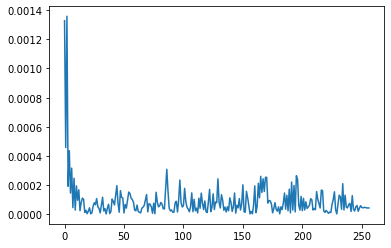

In [21]:
# stft = short-time fourrier transformation. Fourier transformation is a function
# that takes time as the input and outputs frequency. 
# n_fft is the window legth, recommended is 512 for speech.
n_fft = 512
D = np.abs(librosa.stft(sample[:n_fft], n_fft=n_fft, hop_length=n_fft+1))
plt.plot(D);

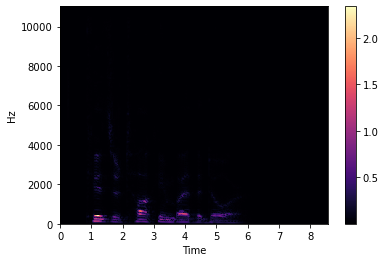

In [26]:
# standard hop length is window length/4
hop_length = 128
D = np.abs(librosa.stft(sample, n_fft=n_fft, hop_length=hop_length))
librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='linear');
plt.colorbar();

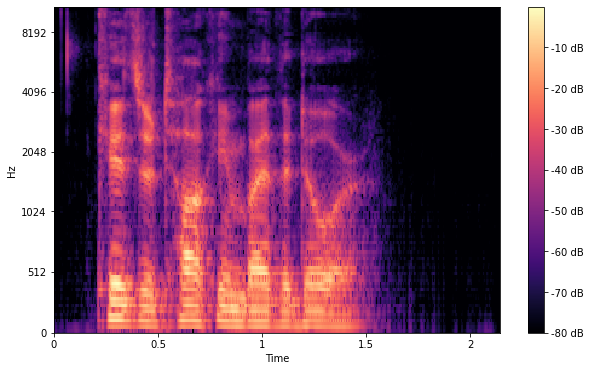

In [83]:
# n_fft is the window legth, recommended is 512 for speech.
n_fft = 512

# standard hop length is window length/4
hop_length = 128

# convert the audio sample to a mel spectrogram. By default it sets the number of mel bins to 128
S = librosa.feature.melspectrogram(sample, sr=sr, n_fft=n_fft, hop_length=hop_length)
# convert a power spectrogram (amplitude squared) to decibels
S_DB = librosa.power_to_db(S, ref=np.max)

# plot
plt.figure(figsize=(10, 6));
librosa.display.specshow(S_DB, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel');
plt.colorbar(format='%+2.0f dB');

# Functions

In [42]:

def scale_minmax(X, min=0.0, max=1.0):
    '''
    Scales and converts the spectrogram to a PNG
    Called by spectrogram_image()
    '''
    X_std = (X - X.min()) / (X.max() - X.min())
    X_scaled = X_std * (max - min) + min
    return X_scaled

def spectrogram_image(wav_file, out_file, hop_length=128, n_mels=128):
    '''
    Converts a WAV file to a spectrogram and sames the image
    
    wav_file: The path to a WAV file as a string
    '''
    # load the audio data
    y, sr = librosa.load(wav_file)
    # trim the white spaces
    sample, _ = librosa.effects.trim(y, top_db=30, ref = np.max, hop_length = 128, frame_length=512)
    # use log-melspectrogram
    mels = librosa.feature.melspectrogram(y=sample, sr=sr, n_mels=n_mels,
                                            n_fft=hop_length*4, hop_length=hop_length)
    # add small number to avoid log(0)
    mels = np.log(mels + 1e-9)

    # min-max scale to fit inside 8-bit range
    img = scale_minmax(mels, 0, 255).astype(np.uint8)
    # put low frequencies at the bottom in image
    img = np.flip(img, axis=0) 
    # invert. make black==more energy
    img = 255-img 
    
    # save the image
    skimage.io.imsave(out_file, img)
    

def make_folder(folder_name):
    '''
    If a folder of previous results exist, delete and create a new folder
    if not, create a new folder
    '''
    try:
        shutil.rmtree('./spectrograms/' + folder_name)
        os.mkdir('./spectrograms/' + folder_name)
    except OSError:
        os.mkdir('./spectrograms/' + folder_name)
        
def loudest_window(spectrogram, win_size = 256):
    '''
    Identifies the loudest window of a specified size within a spectrogram
    '''
    # Convert the array to a spectrogram
    array = np.asarray(spectrogram)
    # get the width of the array
    width = array.shape[1]
    # set the starting and ending of the window
    start = 0
    end = win_size
    arrays = []
    # move the window across the image advancing by 1 pixel.
    # append the array in the window to the list of arrays
    while end <= width:
        window = array[0:128,start:end]
        arrays.append(window)
        start += 1
        end += 1
    # get the sum of each window in the array
    sums = [np.sum(window) for window in arrays]
    # get the index of the smallest window. This will be the loudest section
    index = sums.index(min(sums))
    # pull the loudest window from the list and return it.
    loudest = arrays[index]
    return loudest

def add_silence(spectrogram, min_size = 256):
    '''
    Adds silence to the end of a spectrogram if the spectrogram is shorter than
    the minimum length
    '''
    # get the width of the spectrogram
    width = spectrogram.size[0]
    # subtract the width from the minimum width to determine number of silent columns to add
    n_col = min_size-width
    # create silent columns
    silence = np.full((128, n_col), 255)
    # convert the spectrogram to an array
    spect_ar = np.asarray(spectrogram)
    # add the silence to the spectrogram array
    spect_ar = np.concatenate((spect_ar, silence), axis = 1).astype(np.uint8)
    return spect_ar

def standardize(spect_path):
    '''
    Standardizes an image using the loudest_window() and add_silence() functions
    '''
    im = Image.open(spect_path)
    width = im.size[0]
    # if the width of the spectrogram is less than the minimum, add silence
    if width < 256:
        im = add_silence(im)
    # otherwise get the loudest window
    else:
        im = loudest_window(im)
    im = Image.fromarray(im)
    im.save(spect_path)

to do:

X 1. implement parallel processing 

2. relabel and bin training data

3. convert to class

# Ryerson Spectrograms

In [9]:
%%time
# Serial conversion
# import a list of the audio files to be converted
ryerson = pd.read_csv('ryerson_meta_sub.csv')
ryerson = ryerson['file']

# delete the old folder and create the new one
make_folder('ryerson')

# get the directory of the folders with the wav files
directory = '../Data/ryerson/'

for file in ryerson:
    # get the directory for the individual file
    wav = directory + '/' + file
    # assign a name to the output file
    out = './spectrograms/ryerson/' + file[:-4] + '.png'
    # load the audio data and sample rate
    spectrogram_image(wav_file = wav, out_file = out, hop_length = 128)

CPU times: user 2min 9s, sys: 3min 9s, total: 5min 19s
Wall time: 1min 16s


In [67]:
files

['../Data/ryerson/file',
 '../Data/ryerson/emotion',
 '../Data/ryerson/intensity',
 '../Data/ryerson/statement',
 '../Data/ryerson/repitition',
 '../Data/ryerson/actor']

In [68]:
%%time
# parallel conversion

# get all audio file names
ryerson = pd.read_csv('ryerson_meta_sub.csv')
ryerson = ryerson['file']
# create a list to file paths
files = ['../Data/ryerson/' + file for file in ryerson]
output = ['./spectrograms/ryerson/' + file[:-4] + '.png' for file in ryerson]
args = tuple(zip(files, output))

make_folder('ryerson')

if __name__=='__main__':
    with multiprocessing.Pool(processes = multiprocessing.cpu_count()-1) as pool:
        pool.starmap(spectrogram_image, args)

CPU times: user 22.6 ms, sys: 60.1 ms, total: 82.7 ms
Wall time: 33.3 s


# Crema-d Spectrograms

In [78]:
# Crema-D is not as complete as the ryerson data so it needs to be subset to
# only samples that are complete (recordings for neutral and all emotions)

# import the meta data
cremad = pd.read_csv('cremad_meta_sub.csv')

# Make a list of all the neutral files, then a list of all possible emotional versions
neutral = cremad[cremad['emotion'] == 'neutral']['file']
happy = [file[0:9] + 'HAP' + file[12:] for file in neutral]
sad = [file[0:9] + 'SAD' + file[12:] for file in neutral]
angry = [file[0:9] + 'ANG' + file[12:] for file in neutral]
fearful = [file[0:9] + 'FEA' + file[12:] for file in neutral]
disgust = [file[0:9] + 'DIS' + file[12:] for file in neutral]

# Create a dictionary then create a data frame
d = {
    'neutral': neutral,
    'happy': happy,
    'sad': sad,
    'angry': angry,
    'fearful': fearful,
    'disgust': disgust
}
cremad = pd.DataFrame(d, index = None).reset_index().iloc[:,1:]

# get a list of all the possible files
files = cremad.values.flatten()
# get a list of all the spectrograms
wavs = os.listdir('../Data/crema-d/AudioWAV')

# identify possible files that are missing from actual files
missing = list(set(files) - set(wavs))

# replace missing files with missing values in the df
for file in missing:
    cremad.replace(file, np.nan, inplace = True)
    
# drop incomplete rows 
cremad.dropna(inplace = True)
cremad.reset_index(drop = True)
# return a list of all files that will be used
cremad_files = cremad.values.flatten()

In [32]:
%%time
# serial conversion

try:
    shutil.rmtree('./spectrograms/crema-d')
    os.mkdir('./spectrograms/crema-d')
except OSError:
    os.mkdir('./spectrograms/crema-d')

# get the directory of the folders with the wav files
directory = '../Data/crema-d/AudioWAV'

# loop through files identified as part of a complete set
for file in cremad_files:
    # get the directory for the individual file
    wav = directory + '/' + file
    # assign a name to the output file
    out = './spectrograms/crema-d/' + file[:-4] + '.png'
    # load the audio data and sample rate
    spectrogram_image(wav_file = wav, out_file = out, hop_length = 128)

<ipython-input-7-a5be3a6796b9>:4: RuntimeWarning: invalid value encountered in true_divide
  X_std = (X - X.min()) / (X.max() - X.min())
<ipython-input-7-a5be3a6796b9>:27: UserWarning: ./spectrograms/crema-d/1076_MTI_SAD_XX.png is a low contrast image
  skimage.io.imsave(out_file, img)


CPU times: user 32min 15s, sys: 1h 4min 30s, total: 1h 36min 45s
Wall time: 14min 42s


In [79]:
%%time
# parallel conversion
files = ['../Data/crema-d/AudioWAV/' + file for file in cremad_files]
output = ['./spectrograms/crema-d/' + file[:-4] + '.png' for file in cremad_files]
args = tuple(zip(files, output))

make_folder('crema-d')

if __name__=='__main__':
    with multiprocessing.Pool(processes = multiprocessing.cpu_count()-1) as pool:
        pool.starmap(spectrogram_image, args)

<ipython-input-42-c9a24976b41e>:5: RuntimeWarning: invalid value encountered in true_divide
  X_std = (X - X.min()) / (X.max() - X.min())
<ipython-input-42-c9a24976b41e>:31: UserWarning: ./spectrograms/crema-d/1076_MTI_SAD_XX.png is a low contrast image
  skimage.io.imsave(out_file, img)


CPU times: user 159 ms, sys: 193 ms, total: 352 ms
Wall time: 6min 3s


# Standardizing images

In [59]:
%%time
# folder containing the spectrograms
path = './spectrograms/ryerson/'
# get a list of images
spectrograms = os.listdir(path)
# loop through the list
for png in spectrograms:
    im = Image.open(path + png)
    width = im.size[0]
    # if the width of the spectrogram is less than the minimum, add silence
    if width < 256:
        im = add_silence(im)
    # otherwise get the loudest window
    else:
        im = loudest_window(im)
    # save the standardized image
    im = Image.fromarray(im)
    im.save(path + png)

CPU times: user 516 ms, sys: 15.8 ms, total: 532 ms
Wall time: 531 ms


In [61]:
%%time
# folder containing the spectrograms
path = './spectrograms/crema-d/'
# get a list of images
spectrograms = os.listdir(path)
# loop through the list
for png in spectrograms:
    im = Image.open(path + png)
    width = im.size[0]
    # if the width of the spectrogram is less than the minimum, add silence
    if width < 256:
        im = add_silence(im)
    # otherwise get the loudest window
    else:
        im = loudest_window(im)
    # save the standardized image
    im = Image.fromarray(im)
    im.save(path + png)

CPU times: user 10.8 s, sys: 419 ms, total: 11.2 s
Wall time: 11.3 s


In [71]:
%%time
files = os.listdir('./spectrograms/ryerson/')
spectrograms = ['./spectrograms/ryerson/' + file for file in files]

if __name__=='__main__':
    with multiprocessing.Pool(processes = multiprocessing.cpu_count()-1) as pool:
        pool.map(standardize, spectrograms)

CPU times: user 43.8 ms, sys: 65.3 ms, total: 109 ms
Wall time: 420 ms


In [80]:
%%time
files = os.listdir('./spectrograms/crema-d/')
spectrograms = ['./spectrograms/crema-d/' + file for file in files]

if __name__=='__main__':
    with multiprocessing.Pool(processes = multiprocessing.cpu_count()-1) as pool:
        pool.map(standardize, spectrograms)

CPU times: user 82 ms, sys: 40.9 ms, total: 123 ms
Wall time: 15.3 s


# Ryerson Training data

In [72]:
ryerson = pd.read_csv('ryerson_meta_sub.csv')

neutral = ryerson[ryerson['emotion'] == 'neutral']['file']
happy = [file[0:6] + '03-02' + file[11:] for file in neutral]
sad = [file[0:6] + '04-02' + file[11:] for file in neutral]
angry = [file[0:6] + '05-02' + file[11:] for file in neutral]
fearful = [file[0:6] + '06-02' + file[11:] for file in neutral]
disgust = [file[0:6] + '07-02' + file[11:] for file in neutral]

d = {
    'neutral': neutral,
    'happy': happy,
    'sad': sad,
    'angry': angry,
    'fearful': fearful,
    'disgust': disgust
}
training = pd.DataFrame(d, index = None).reset_index(drop=True)
training.replace('.wav', '.png', regex=True, inplace = True)
training.head()

,neutral,happy,sad,angry,fearful,disgust
0,03-01-01-01-02-01-15.png,03-01-03-02-02-01-15.png,03-01-04-02-02-01-15.png,03-01-05-02-02-01-15.png,03-01-06-02-02-01-15.png,03-01-07-02-02-01-15.png
1,03-01-01-01-01-01-15.png,03-01-03-02-01-01-15.png,03-01-04-02-01-01-15.png,03-01-05-02-01-01-15.png,03-01-06-02-01-01-15.png,03-01-07-02-01-01-15.png
2,03-01-01-01-01-01-02.png,03-01-03-02-01-01-02.png,03-01-04-02-01-01-02.png,03-01-05-02-01-01-02.png,03-01-06-02-01-01-02.png,03-01-07-02-01-01-02.png
3,03-01-01-01-02-01-02.png,03-01-03-02-02-01-02.png,03-01-04-02-02-01-02.png,03-01-05-02-02-01-02.png,03-01-06-02-02-01-02.png,03-01-07-02-02-01-02.png
4,03-01-01-01-01-01-08.png,03-01-03-02-01-01-08.png,03-01-04-02-01-01-08.png,03-01-05-02-01-01-08.png,03-01-06-02-01-01-08.png,03-01-07-02-01-01-08.png


In [73]:
# copy all files to discrete emotion folders
for col in training.columns:
    make_folder(col)
    pngs = training[col]
    for png in pngs:
        shutil.copy('./spectrograms/ryerson/' + png, './spectrograms/'+ col + '/' + png)

# Crema-d training data

In [82]:
# use the previously created cremad df, replace .wav with .png
cremad.replace('.wav', '.png', regex=True, inplace = True)

for col in cremad.columns:
    pngs = cremad[col]
    for png in pngs:
        shutil.copy('./spectrograms/crema-d/' + png, './spectrograms/'+ col + '/' + png)